# Hi!5 predictions

In [33]:
import json
import os 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torch import nn
from torch import optim
from PIL import Image
from matplotlib.ticker import FormatStrFormatter
from torchvision import datasets, transforms, models

In [15]:
test_images_path = '../datasets/datasets_test/test/'
test_images = os.listdir(test_images_path)
test_images = np.array(test_images)

In [14]:
n = len(test_images)
print(f'We must provide {n} predictions.')

We must provide 1025 predictions.


---

**MAIN GOAL :**

We will have an image as an input. The goal here is to predict if there is a car on this image, and if it's the case, provide the bounding box of the car and predict it CO2 emissions.

---

## Task 1 : Predict CO2 emissions 

In [4]:
train_dir = '/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/group_00093_shared_workspace/car_data/car_data/train'

### Useful functions

In [5]:
def process_image(image):
    # Process a PIL image for use in a PyTorch model
    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}')
    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd) 
    return array_im_tfd


def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model).cpu()
    loaded_model.to('cuda')
    #loaded_model = loaded_model.to(f'cuda:{loaded_model.device_ids[0]}')
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)
    img_add_dim = img_add_dim.to('cuda')
    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)
    
    output = output.cpu()
    #conf, predicted = torch.max(output.data, 1)   
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]
    
    n = len(predicted)
    i = 0
    found = False
    while not found and (i < n):
        pred = predicted[i]
        if pred in our_indexes:
            res = pred
            found = True
        i+=1
     
    #return probs_top_list, index_top_list
    return idx_to_class[res]

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    idx_to_class = {i: classes[i] for i in range(len(classes))}
    return classes, class_to_idx, idx_to_class

def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)
    
    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

We open the model we have trained thanks to the Stanford car images dataset.
This model predict 196 classes, but we have only 100 of these 196 classes in our proper dataset.

In [6]:
classes, c_to_idx, idx_to_class = find_classes(train_dir)

Let's find the commun class between both datasets :

In [7]:
df_annotations = pd.read_csv('df_annotations.csv')
our_cars = np.array(df_annotations.models)
stanford_cars = np.array(list(c_to_idx.keys()))
our_indexes = np.argwhere(np.isin(stanford_cars, our_cars)).flatten()

Once we have recognized the car model, we will deduce the CO2 consumption using the following csv file (car_models_footprint)

In [18]:
cars_path = "../datasets/car_models_footprint.csv"
car_models = pd.read_csv(cars_path, sep=";")

Let's load the model we have trained to recognize the model of a car among 100 possible models.

In [19]:
# Loading model
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)
model_path = 'my_checkpoint1.pth'

**Example on one image**

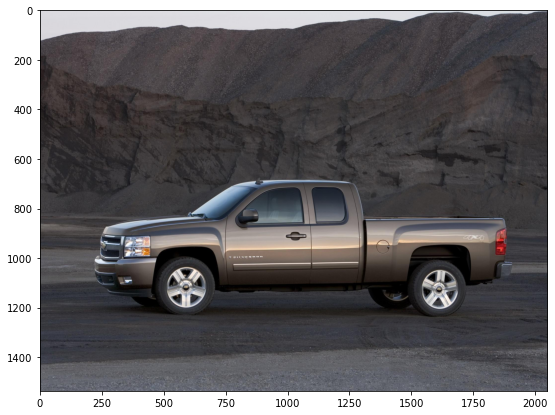

We predict that this car is a Chevrolet Silverado 1500 Extended Cab 2012.
Consequently, we predict that e = 201.72 g per km.


In [26]:
image = test_images[0]
image_path = f'../datasets/datasets_test/test/{image}'
im = plt.imread(image_path)
plt.figure(figsize=(15, 7))
plt.imshow(im)
plt.show()
pred = predict(image_path, model_path, topk=10)
print(f'We predict that this car is a {pred}.')
conso = car_models.query(f'models=="{pred}"')["Average of CO2 (g per km)"].values[0]
print(f'Consequently, we predict that e = {conso:.2f} g per km.')

In [28]:
# To get a csv with all results
'''
df_res = pd.DataFrame()
for image in test_images[915:]:
    print(image)
    image_path = f'../datasets/datasets_test/test/{image}'
    pred = predict(image_path, model_path, topk=10)
    conso = car_models.query(f'models=="{pred}"')["Average of CO2 (g per km)"].values[0]
    print(conso)
    print(pred)
    res = [[image, pred, conso]]
    df_tmp = pd.DataFrame(res, columns=['im_name', 'model', 'e'])
    df_res = pd.concat((df_res, df_tmp))
    print()
'''

'\ndf_res = pd.DataFrame()\nfor image in test_images[915:]:\n    print(image)\n    image_path = f\'../datasets/datasets_test/test/{image}\'\n    pred = predict(image_path, model_path, topk=10)\n    conso = car_models.query(f\'models=="{pred}"\')["Average of CO2 (g per km)"].values[0]\n    print(conso)\n    print(pred)\n    res = [[image, pred, conso]]\n    df_tmp = pd.DataFrame(res, columns=[\'im_name\', \'model\', \'e\'])\n    df_res = pd.concat((df_res, df_tmp))\n    print()\n'

## Task 2  : predict bounding boxes

### Useful functions

In [31]:
def get_box(path):
    x, orig_img = data.transforms.presets.rcnn.load_test(path)
    im = plt.imread(path)
    n = im.shape[0]
    m = im.shape[1]
    n1 = orig_img.shape[0]
    m1 = orig_img.shape[1]
    ids, scores, bboxes = [xx[0].asnumpy() for xx in net(x)]
    ids = ids.flatten()
    scores = scores.flatten()
    
    pot_indexes = np.argwhere(ids == 6).flatten()
    if len(pot_indexes) == 0 :
        return -1, -1, -1, -1

    if len(pot_indexes) > 0 :
        pot_indexes = pot_indexes[np.argwhere(scores.flatten()[pot_indexes] > 0.6).flatten()]
        if len(pot_indexes) == 0 :
            return -1, -1, -1, -1
        else :
            pot_boxes = bboxes[pot_indexes]
            largeurs = []
            for bbox in pot_boxes:
                largeurs.append(bbox[2] - bbox[0])
            largeurs = np.array(largeurs)
            bbox = pot_boxes[np.argmax(largeurs)]
            [x1, y1, x2, y2] = bbox
            x1 = x1 * n / n1
            x2 = x2 * n / n1
            y1 = y1 * m / m1
            y2 = y2 * m / m1
            return x1, y1, x2, y2

In [29]:
!pip install gluoncv
!pip install mxnet

We will use the pre-trained model yolo3_darknet53 provided by the gluoncv library. Let's load it :

In [37]:
from gluoncv import model_zoo, data, utils

net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)
id_car = np.argwhere(np.array(net.classes) == 'car')[0][0]

/opt/conda/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


**Example on one image**

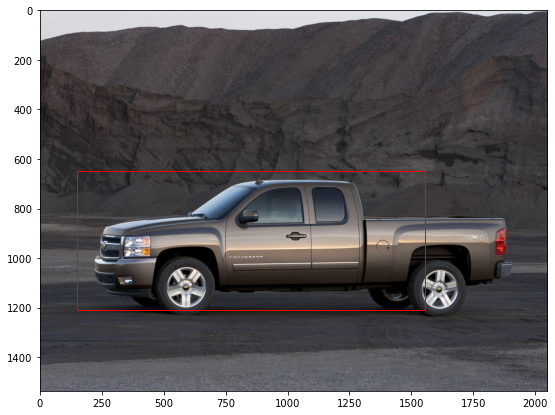

In [38]:
image = test_images[0]
image_path = f'../datasets/datasets_test/test/{image}'

x1, y1, x2, y2 = get_box(image_path) #our prediction

#Plot
im = plt.imread(image_path)
fig, ax = plt.subplots(figsize=(15, 7))
plt.imshow(im)
rect = patches.Rectangle(
    (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
)
ax.add_patch(rect)
plt.show()

In [40]:
# To get a csv with all results

'''
df_res = pd.DataFrame()
columns = ['im_name', 'x_min', 'y_min', 'x_max', 'y_max']

for i, image in enumerate(test_images[915:]):
    print(i, image)
    image_path = f'../datasets/datasets_test/test/{image}'
    x1, y1, x2, y2 = get_box(image_path)
    res = [[image, x1, y1, x2, y2]]
    df_tmp = pd.DataFrame(res, columns=columns)
    df_res = pd.concat((df_res, df_tmp))
df_res.to_csv('final_results/bbox2.csv')
'''

"\ndf_res = pd.DataFrame()\ncolumns = ['im_name', 'x_min', 'y_min', 'x_max', 'y_max']\n\nfor i, image in enumerate(test_images[915:]):\n    print(i, image)\n    image_path = f'../datasets/datasets_test/test/{image}'\n    x1, y1, x2, y2 = get_box(image_path)\n    res = [[image, x1, y1, x2, y2]]\n    df_tmp = pd.DataFrame(res, columns=columns)\n    df_res = pd.concat((df_res, df_tmp))\ndf_res.to_csv('final_results/bbox2.csv')\n"

In [45]:
#df_final_result_all = df_res_tot.merge(df_res_bbox, on='im_name')

Our model predict a car model even when there is no car on the image. To deal with it, when we find no bounding_box (when we estimate that there is no car on the image), we supress the car model and the emission.

In [46]:
df_final_result_all = pd.read_csv('final_results/group11.csv', sep=';')

In [47]:
df_final_result_all.loc[df_final_result_all.x_min==-1, 'model'] = ''
df_final_result_all.loc[df_final_result_all.x_min==-1, 'e'] = ''

### Let's check some examples 

In [44]:
df_final_result_all.head()

Unnamed: 0          im_name                                       model  \
0           0     85854523.jpg  Chevrolet Silverado 1500 Extended Cab 2012   
1           1  16663988681.jpg                                         NaN   
2           2  19090334369.jpg                                         NaN   
3           3     71540198.jpg                           BMW M5 Sedan 2010   
4           4     85427036.jpg                         Volvo XC90 SUV 2007   

            e       x_min       y_min        x_max        y_max  
0  201.717391  151.773047  648.990156  1553.263438  1208.183281  
1         NaN   -1.000000   -1.000000    -1.000000    -1.000000  
2         NaN   -1.000000   -1.000000    -1.000000    -1.000000  
3  185.883392  388.950900   72.020795  1486.272107   846.720050  
4  212.539749  278.712896  197.885819  1019.519975   641.648879

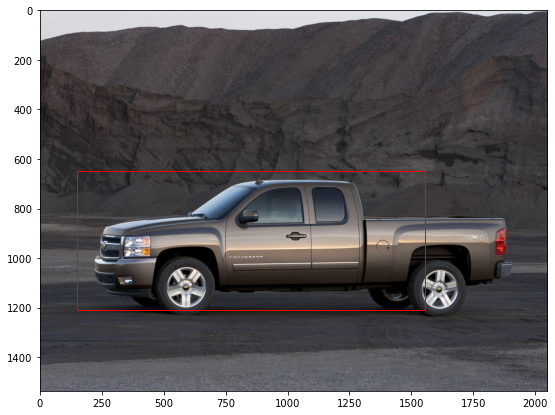

We predict this is a Chevrolet Silverado 1500 Extended Cab 2012.


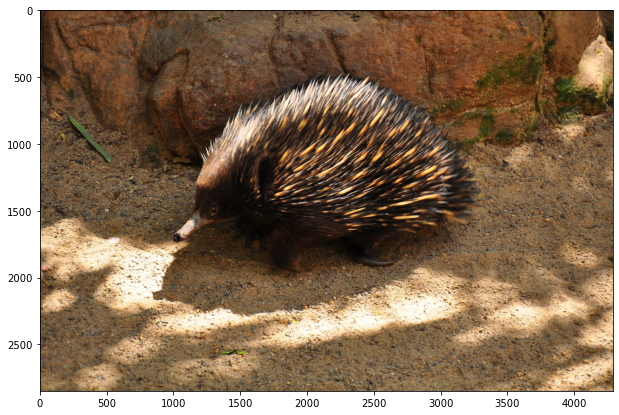

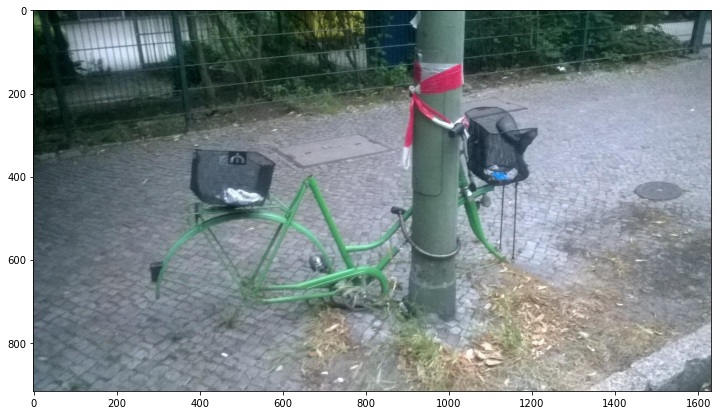

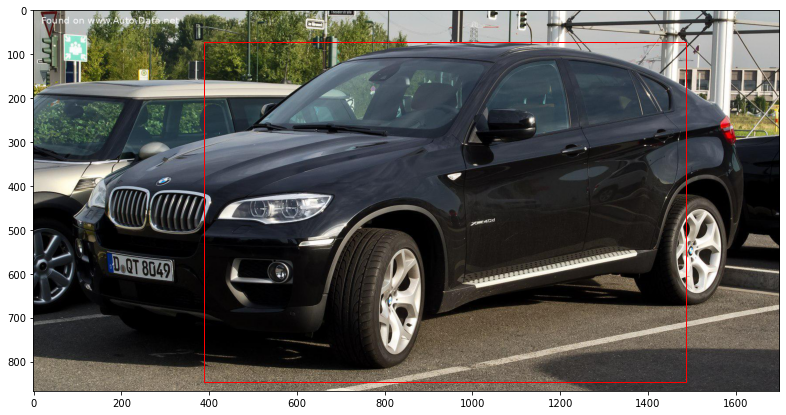

We predict this is a BMW M5 Sedan 2010.


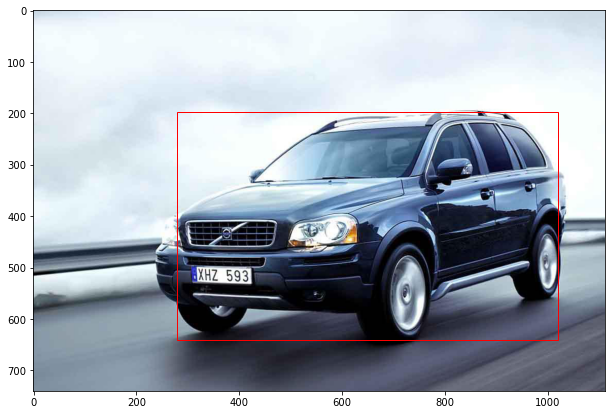

We predict this is a Volvo XC90 SUV 2007.


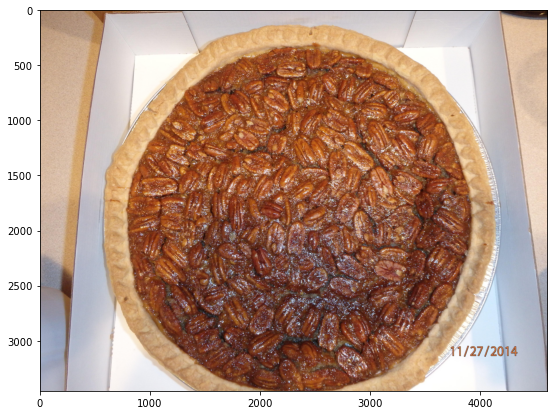

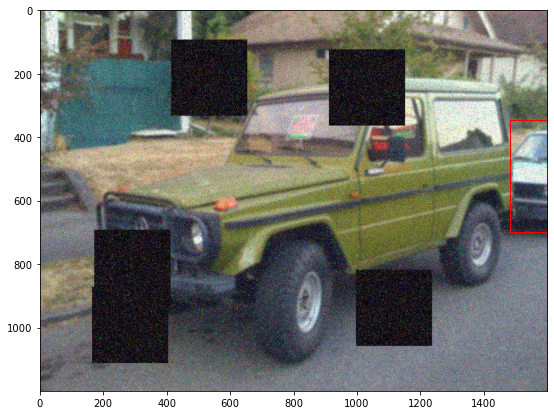

We predict this is a Ford Ranger SuperCab 2011.


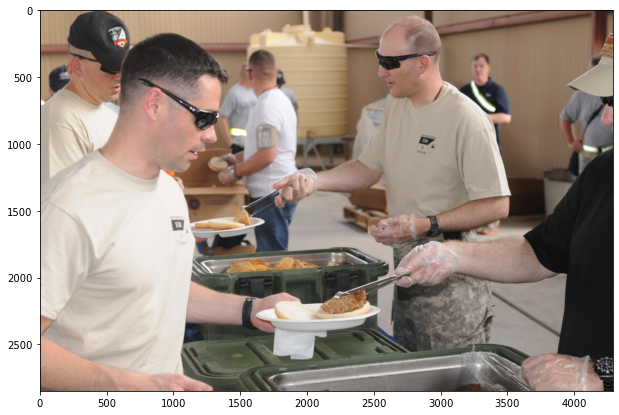

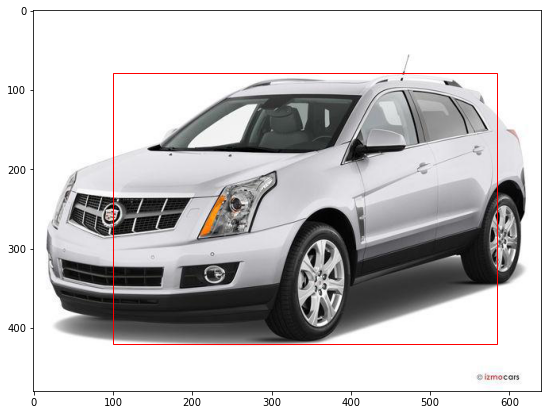

We predict this is a Suzuki Aerio Sedan 2007.


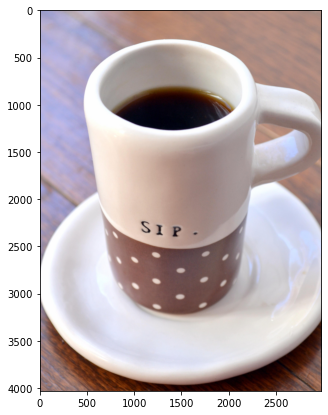

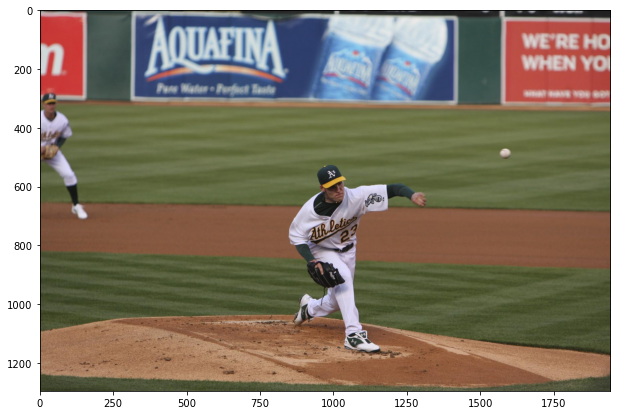

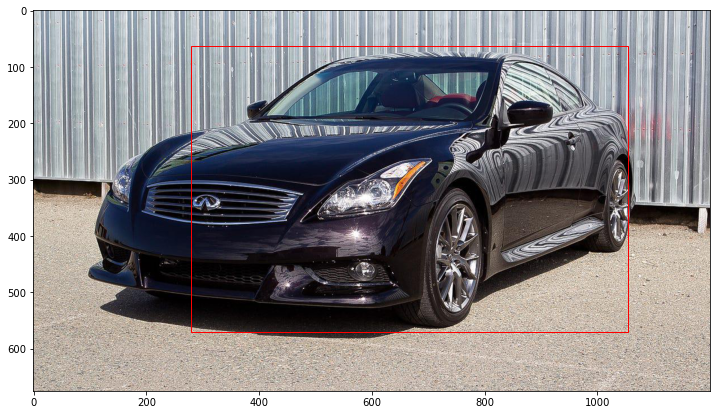

We predict this is a Chevrolet Corvette ZR1 2012.


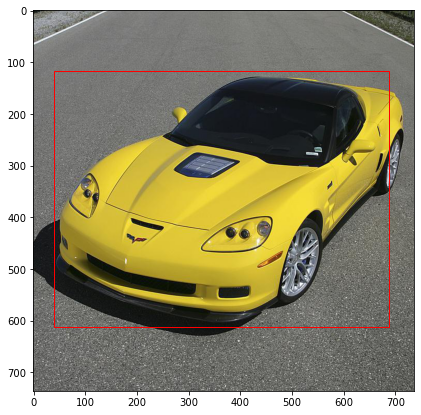

We predict this is a Chevrolet Corvette ZR1 2012.


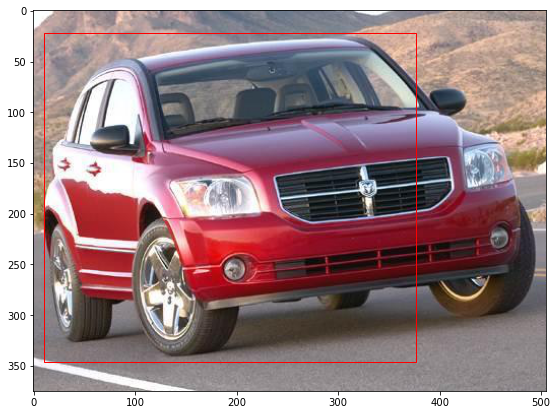

We predict this is a Dodge Charger Sedan 2012.


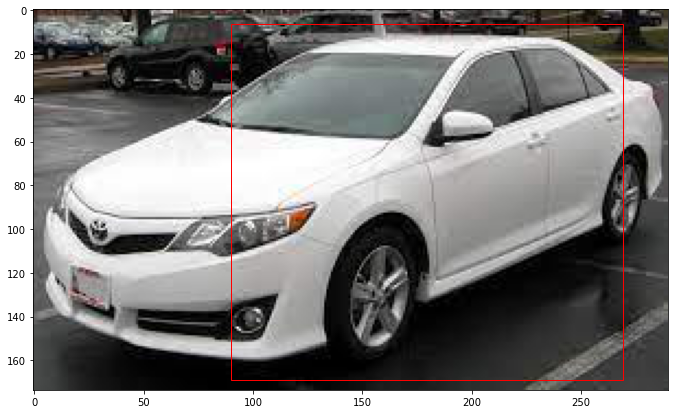

We predict this is a Scion xD Hatchback 2012.


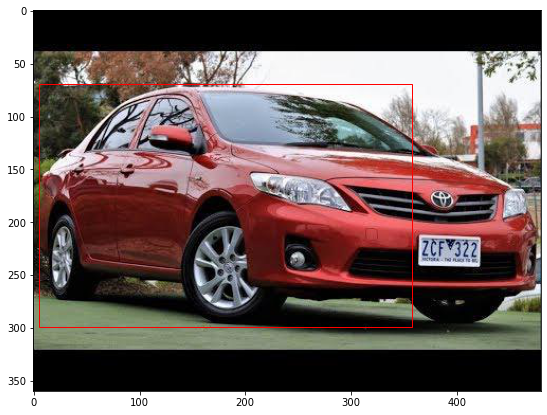

We predict this is a Toyota Corolla Sedan 2012.


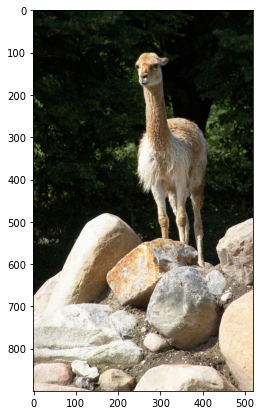

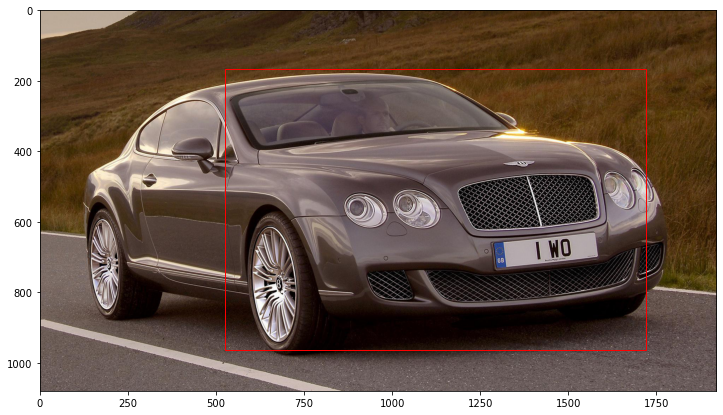

We predict this is a Bentley Continental GT Coupe 2007.


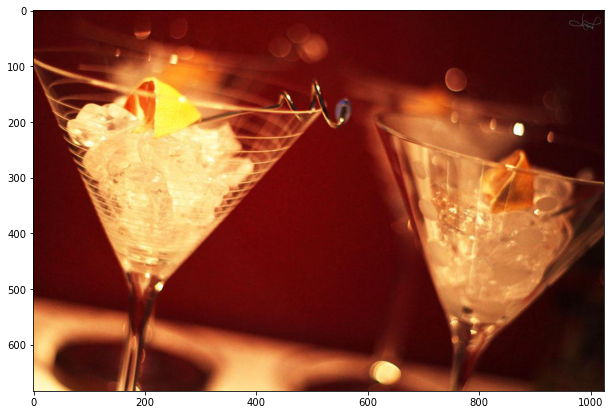

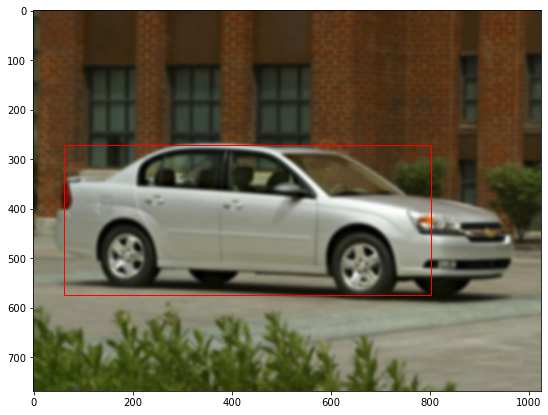

We predict this is a Maybach Landaulet Convertible 2012.


In [50]:
for i in range(20):
    row = df_final_result_all.iloc[i]
    im_path = f'../datasets/datasets_test/test/{row.im_name}'
    im = plt.imread(im_path)
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.imshow(im)
    
    rect = patches.Rectangle(
        (row.x_min, row.y_min), row.x_max - row.x_min, row.y_max - row.y_min, linewidth=1, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect)
    plt.show()
    model = row.model
    if len(model) > 0 :
        print(f'We predict this is a {model}.')

We are quiet good to predict the car model, but we could have been largely better on the bounding boxes, by using a more powerful pretrained model